In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import pickle
import networkx as nx
import random
from itertools import combinations
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import shap

Load & Sample the Data

In [2]:
trade_2007_2012_path = "/home/nofarse/project/extracted_trade_matrix/US_TradeMatrix_20072012.csv"  
trade_2019_2023_path = "/home/nofarse/project/extracted_trade_matrix/US_TradeMatrix_20192023.csv"
port_calls_path = "/home/nofarse/project/extracted_port_calls/US_PortCallsArrivals.csv"

In [3]:
# Load only the first 2 million rows from each dataset
trade_2007_2012 = pd.read_csv(trade_2007_2012_path, nrows=2_000_000)
trade_2019_2023 = pd.read_csv(trade_2019_2023_path, nrows=2_000_000)
port_calls = pd.read_csv(port_calls_path)

# Display basic information
print("✅ Trade 2007-2012 Sample Size:", trade_2007_2012.shape)
print("✅ Trade 2019-2023 Sample Size:", trade_2019_2023.shape)
print("✅ Port Calls Sample Size:", port_calls.shape)

/tmp/ipykernel_1029788/3399322589.py:2: DtypeWarning: Columns (11,14,17) have mixed types. Specify dtype option on import or set low_memory=False.
  trade_2007_2012 = pd.read_csv(trade_2007_2012_path, nrows=2_000_000)
/tmp/ipykernel_1029788/3399322589.py:3: DtypeWarning: Columns (11,14,17) have mixed types. Specify dtype option on import or set low_memory=False.
  trade_2019_2023 = pd.read_csv(trade_2019_2023_path, nrows=2_000_000)


✅ Trade 2007-2012 Sample Size: (2000000, 18)
✅ Trade 2019-2023 Sample Size: (2000000, 18)
✅ Port Calls Sample Size: (4653, 8)


In [4]:
# Check for missing values
print("\n🔍 Missing Values in Trade 2007-2012:\n", trade_2007_2012.isnull().sum())
print("\n🔍 Missing Values in Trade 2019-2023:\n", trade_2019_2023.isnull().sum())
print("\n🔍 Missing Values in Port Calls:\n", port_calls.isnull().sum())


🔍 Missing Values in Trade 2007-2012:
 Year                                                             0
Economy                                                          0
Economy Label                                                    0
Partner                                                          0
Partner Label                                                    0
Flow                                                             0
Flow Label                                                       0
Product                                                          0
Product Label                                                    0
US$ at current prices in thousands                           88008
US$ at current prices in thousands Footnote                2000000
US$ at current prices in thousands Missing value           1911992
Percentage by destination                                    88008
Percentage by destination Footnote                         2000000
Percentage by destinati

In [5]:
# Check data types
print("\n📊 Trade 2007-2012 Data Types:\n", trade_2007_2012.dtypes)
print("\n📊 Trade 2019-2023 Data Types:\n", trade_2019_2023.dtypes)
print("\n📊 Port Calls Data Types:\n", port_calls.dtypes)


📊 Trade 2007-2012 Data Types:
 Year                                                         int64
Economy                                                      int64
Economy Label                                               object
Partner                                                      int64
Partner Label                                               object
Flow                                                         int64
Flow Label                                                  object
Product                                                     object
Product Label                                               object
US$ at current prices in thousands                         float64
US$ at current prices in thousands Footnote                float64
US$ at current prices in thousands Missing value            object
Percentage by destination                                  float64
Percentage by destination Footnote                         float64
Percentage by destination Miss

In [6]:
# Display first few rows
print("\n📌 Sample of Trade 2007-2012 Data:\n", trade_2007_2012.head())
print("\n📌 Sample of Trade 2019-2023 Data:\n", trade_2019_2023.head())
print("\n📌 Sample of Port Calls Data:\n", port_calls.head())


📌 Sample of Trade 2007-2012 Data:
    Year  Economy Economy Label  Partner Partner Label  Flow Flow Label  \
0  2007        0         World        0         World     2    Exports   
1  2007        0         World        0         World     2    Exports   
2  2007        0         World        0         World     2    Exports   
3  2007        0         World        0         World     2    Exports   
4  2007        0         World        0         World     2    Exports   

  Product                                      Product Label  \
0   TOTAL                                 TOTAL ALL PRODUCTS   
1     A00   All allocated products (SITC 0 to 8 + 961 + 971)   
2     A11  Primary commodities, precious stones and non-m...   
3     A20  Primary commodities (SITC 0 + 1 + 2 + 3 + 4 + 68)   
4     A13  Primary commodities, excluding fuels (SITC 0 +...   

   US$ at current prices in thousands  \
0                        1.401965e+10   
1                        1.352811e+10   
2          

Data Cleaning & Preparation

In [7]:
# Drop footnotes & missing value columns (since they are mostly empty)
columns_to_drop = [
    "US$ at current prices in thousands Footnote", 
    "US$ at current prices in thousands Missing value",
    "Percentage by destination Footnote", 
    "Percentage by destination Missing value",
    "Percentage by product or group of product Footnote",
    "Percentage by product or group of product Missing value"
]

trade_2007_2012_clean = trade_2007_2012.drop(columns=columns_to_drop)
trade_2019_2023_clean = trade_2019_2023.drop(columns=columns_to_drop)

# Drop missing value & footnote columns in Port Calls dataset
port_calls_clean = port_calls.drop(columns=["Number of port calls Footnote", "Number of port calls Missing value"])

print("✅ Irrelevant columns dropped!")

✅ Irrelevant columns dropped!


In [8]:
# Convert object columns to float where needed
columns_to_convert = [
    "US$ at current prices in thousands", 
    "Percentage by destination", 
    "Percentage by product or group of product"
]

for col in columns_to_convert:
    trade_2007_2012_clean[col] = pd.to_numeric(trade_2007_2012_clean[col], errors='coerce')
    trade_2019_2023_clean[col] = pd.to_numeric(trade_2019_2023_clean[col], errors='coerce')

port_calls_clean["Number of port calls"] = pd.to_numeric(port_calls_clean["Number of port calls"], errors='coerce')

print("✅ Data types converted!")

✅ Data types converted!


In [9]:
# Fill missing values with median for trade datasets
for col in columns_to_convert:
    trade_2007_2012_clean[col].fillna(trade_2007_2012_clean[col].median(), inplace=True)
    trade_2019_2023_clean[col].fillna(trade_2019_2023_clean[col].median(), inplace=True)

# Fill missing values in port calls dataset
port_calls_clean["Number of port calls"].fillna(port_calls_clean["Number of port calls"].median(), inplace=True)

print("✅ Missing values handled!")

✅ Missing values handled!


/tmp/ipykernel_1029788/3311455418.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trade_2007_2012_clean[col].fillna(trade_2007_2012_clean[col].median(), inplace=True)
/tmp/ipykernel_1029788/3311455418.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

In [10]:
# Merge Port Calls with Trade Data on Economy & Year
trade_2007_2012_final = trade_2007_2012_clean.merge(port_calls_clean, on=["Economy", "Year"], how="left")
trade_2019_2023_final = trade_2019_2023_clean.merge(port_calls_clean, on=["Economy", "Year"], how="left")

print("✅ Datasets merged successfully!")

✅ Datasets merged successfully!


Exploratory Data Analysis (EDA)

In [11]:
# Basic Summary
print("📊 Trade 2007-2012 Summary Statistics:\n", trade_2007_2012_final.describe())
print("\n📊 Trade 2019-2023 Summary Statistics:\n", trade_2019_2023_final.describe())
print("\n📊 Port Calls Summary Statistics:\n", port_calls_clean.describe())

📊 Trade 2007-2012 Summary Statistics:
             Year       Economy       Partner          Flow  \
count  2000000.0  2.000000e+06  2.000000e+06  2.000000e+06   
mean      2007.0  4.626240e+03  1.480514e+03  1.504896e+00   
std          0.0  1.586849e+03  1.849355e+03  4.999762e-01   
min       2007.0  0.000000e+00  0.000000e+00  1.000000e+00   
25%       2007.0  5.120000e+03  3.160000e+02  1.000000e+00   
50%       2007.0  5.124000e+03  6.420000e+02  2.000000e+00   
75%       2007.0  5.220000e+03  1.601000e+03  2.000000e+00   
max       2007.0  5.300000e+03  5.900000e+03  2.000000e+00   

       US$ at current prices in thousands  Percentage by destination  \
count                        2.000000e+06               2.000000e+06   
mean                         2.806203e+06               6.213161e+00   
std                          6.330142e+07               1.696173e+01   
min                         -1.000000e-03               0.000000e+00   
25%                          5.002875e+01 

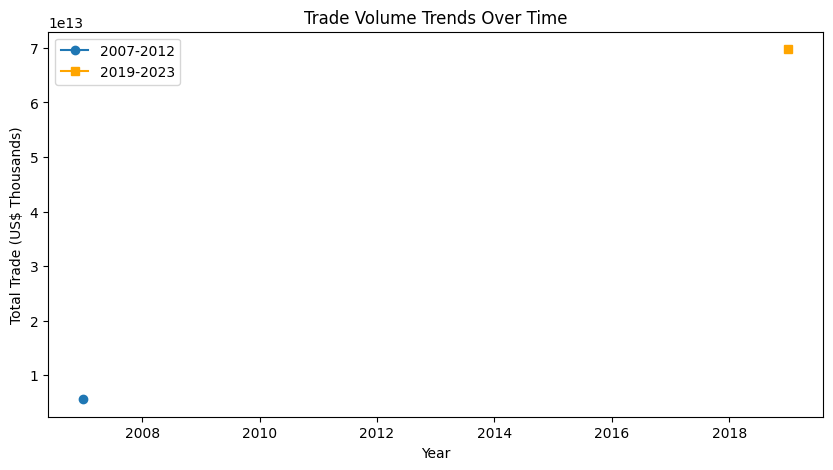

In [12]:
# Aggregate total trade per year
trade_2007_trend = trade_2007_2012_final.groupby("Year")["US$ at current prices in thousands"].sum()
trade_2019_trend = trade_2019_2023_final.groupby("Year")["US$ at current prices in thousands"].sum()

# Plot trade volume trends
plt.figure(figsize=(10, 5))
plt.plot(trade_2007_trend.index, trade_2007_trend.values, marker='o', label="2007-2012")
plt.plot(trade_2019_trend.index, trade_2019_trend.values, marker='s', label="2019-2023", color='orange')

plt.xlabel("Year")
plt.ylabel("Total Trade (US$ Thousands)")
plt.title("Trade Volume Trends Over Time")
plt.legend()
plt.show()

In [13]:
# Identify top economies by total trade volume
top_economies_2007 = trade_2007_2012_final.groupby("Economy")["US$ at current prices in thousands"].sum().nlargest(10)
top_economies_2019 = trade_2019_2023_final.groupby("Economy")["US$ at current prices in thousands"].sum().nlargest(10)

# Identify most common trading partners
top_partners_2007 = trade_2007_2012_final["Partner Label"].value_counts().head(10)
top_partners_2019 = trade_2019_2023_final["Partner Label"].value_counts().head(10)

print("🏆 Top 10 Trading Economies (2007-2012):\n", top_economies_2007)
print("\n🏆 Top 10 Trading Economies (2019-2023):\n", top_economies_2019)
print("\n🌍 Most Common Trading Partners (2007-2012):\n", top_partners_2007)
print("\n🌍 Most Common Trading Partners (2019-2023):\n", top_partners_2019)

🏆 Top 10 Trading Economies (2007-2012):
 Economy
0       3.460963e+12
5200    6.834410e+11
5210    4.964256e+11
5300    3.487592e+11
5220    1.870232e+11
5223    1.002249e+11
5100    9.384546e+10
5222    7.606324e+10
5120    6.103341e+10
5110    3.281985e+10
Name: US$ at current prices in thousands, dtype: float64

🏆 Top 10 Trading Economies (2019-2023):
 Economy
0       4.318350e+13
5200    8.121553e+12
5210    5.714106e+12
5300    4.638198e+12
5220    2.407485e+12
5100    1.226920e+12
5223    1.186486e+12
5222    1.126216e+12
5120    8.192937e+11
5110    4.076637e+11
Name: US$ at current prices in thousands, dtype: float64

🌍 Most Common Trading Partners (2007-2012):
 Partner Label
Curacao                             11580
Bonaire, Sint Eustatius and Saba    11580
World                               11449
Europe                              11360
Asia                                11262
Western Europe                      11249
Americas                            11237
Africa       

/home/nofarse/.conda/envs/my_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


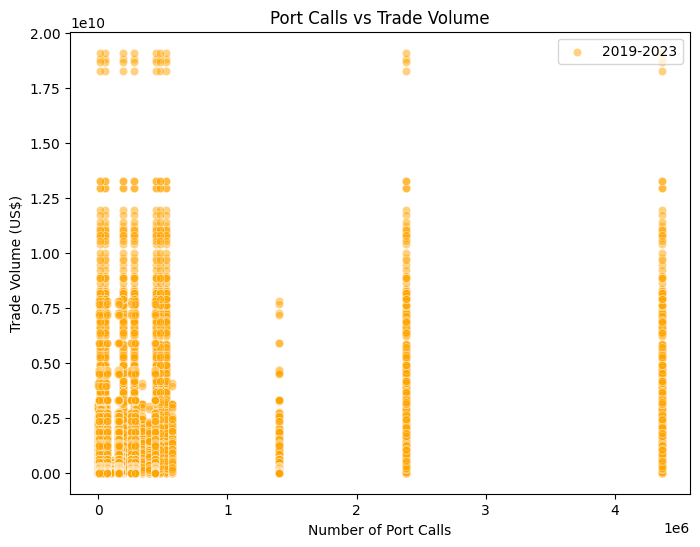

In [14]:
# Scatter plot of trade volume vs. port calls
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=trade_2007_2012_final["Number of port calls"], 
    y=trade_2007_2012_final["US$ at current prices in thousands"],
    alpha=0.5, label="2007-2012"
)
sns.scatterplot(
    x=trade_2019_2023_final["Number of port calls"], 
    y=trade_2019_2023_final["US$ at current prices in thousands"],
    alpha=0.5, color="orange", label="2019-2023"
)
plt.xlabel("Number of Port Calls")
plt.ylabel("Trade Volume (US$)")
plt.title("Port Calls vs Trade Volume")
plt.legend()
plt.show()

Graph-Based Forecasting & Trade Prediction

In [15]:
# ✅ Create a directed graph
G = nx.DiGraph()

# ✅ Add edges from the trade data (both datasets)
def add_trade_edges(graph, trade_data):
    for _, row in trade_data.iterrows():
        economy = row["Economy"]
        partner = row["Partner"]
        trade_volume = row["US$ at current prices in thousands"]

        # Add an edge with weight = trade volume
        graph.add_edge(economy, partner, weight=trade_volume)

# ✅ Apply to both datasets
add_trade_edges(G, trade_2007_2012_final)
add_trade_edges(G, trade_2019_2023_final)

# ✅ Print summary
print(f"✅ Graph Created: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Save graph
with open("trade_network.gpickle", "wb") as f:
    pickle.dump(G, f)

# Load graph (if needed)
with open("trade_network.gpickle", "rb") as f:
    G_loaded = pickle.load(f)

print("✅ Graph saved and loaded successfully!")

✅ Graph Created: 303 nodes, 4354 edges
✅ Graph saved and loaded successfully!


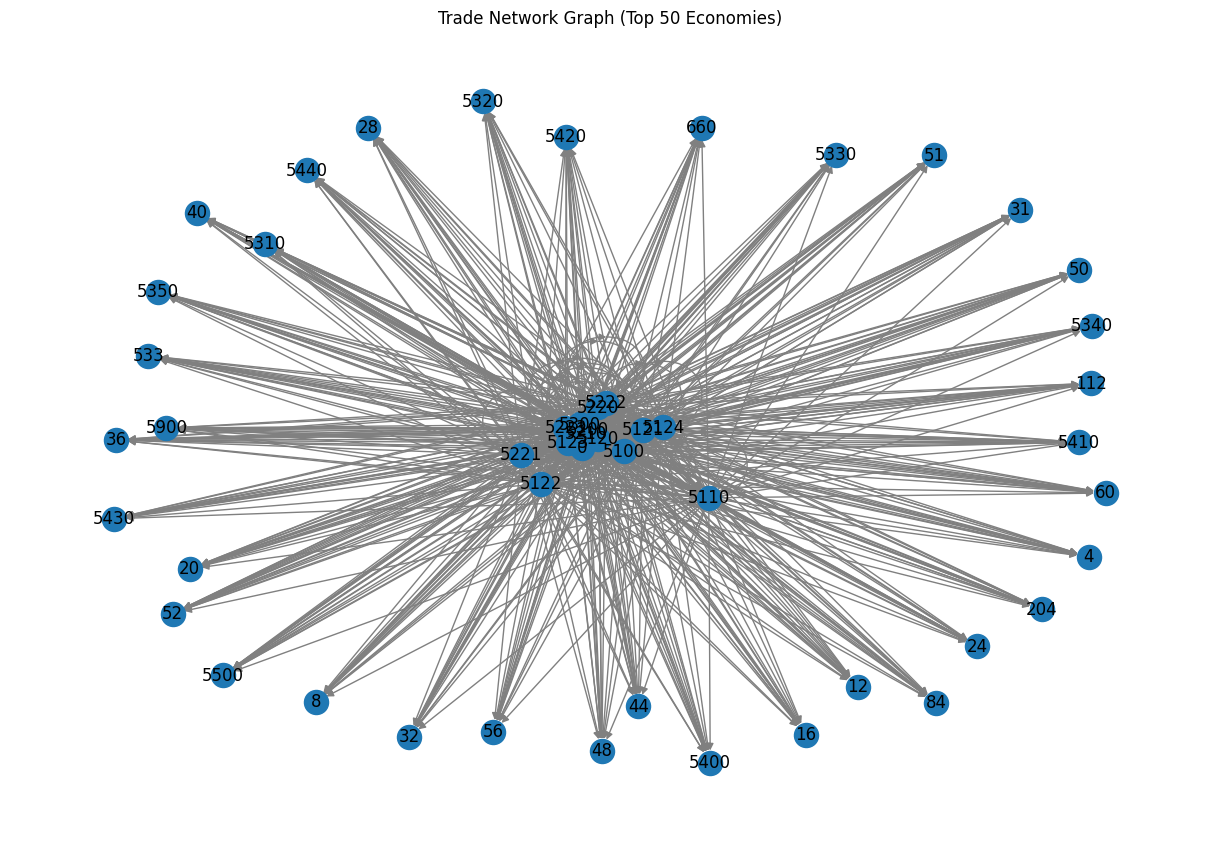

In [16]:
# ✅ Draw a small subgraph (showing top 50 trade economies)
subgraph_nodes = list(dict(G.degree()).keys())[:50]
subG = G.subgraph(subgraph_nodes)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subG, seed=42)  # Layout
nx.draw(subG, pos, with_labels=True, node_size=300, edge_color="gray")
plt.title("Trade Network Graph (Top 50 Economies)")
plt.show()

In [17]:
# Calculate Degree Centrality
degree_centrality = nx.degree_centrality(G)
top_central_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("📌 Top 10 Nodes by Degree Centrality:")
for node, centrality in top_central_nodes:
    print(f"Node {node}: {centrality:.4f}")

# Compute Network Density
density = nx.density(G)
print(f"🌍 Network Density: {density:.6f}")

# Compute Clustering Coefficient (only works for undirected graphs)
if not G.is_directed():
    clustering_coeff = nx.average_clustering(G)
    print(f"🔗 Average Clustering Coefficient: {clustering_coeff:.6f}")
else:
    print("🔗 Clustering Coefficient is not supported for directed graphs.")

# Compute Shortest Path Length for the largest strongly connected component
if nx.is_strongly_connected(G):
    avg_shortest_path = nx.average_shortest_path_length(G)
    print(f"📏 Average Shortest Path Length (Strongly Connected Graph): {avg_shortest_path:.4f}")
else:
    # Find the largest strongly connected component
    largest_component = max(nx.strongly_connected_components(G), key=len)
    subgraph = G.subgraph(largest_component).copy()  # Copy subgraph to maintain structure
    
    avg_shortest_path = nx.average_shortest_path_length(subgraph)
    print(f"📏 Average Shortest Path Length (Largest Strongly Connected Component): {avg_shortest_path:.4f}")

📌 Top 10 Nodes by Degree Centrality:
Node 0: 1.0530
Node 5200: 1.0530
Node 5220: 1.0530
Node 5100: 1.0497
Node 5120: 1.0497
Node 5122: 1.0497
Node 5221: 1.0497
Node 5121: 1.0464
Node 5123: 1.0464
Node 5124: 1.0464
🌍 Network Density: 0.047582
🔗 Clustering Coefficient is not supported for directed graphs.
📏 Average Shortest Path Length (Largest Strongly Connected Component): 1.0000


🏆 Top 10 Trade Hubs (Most Connected Nodes):
Node 0: 318 connections
Node 5200: 318 connections
Node 5220: 318 connections
Node 5100: 317 connections
Node 5120: 317 connections
Node 5122: 317 connections
Node 5221: 317 connections
Node 5121: 316 connections
Node 5123: 316 connections
Node 5124: 316 connections


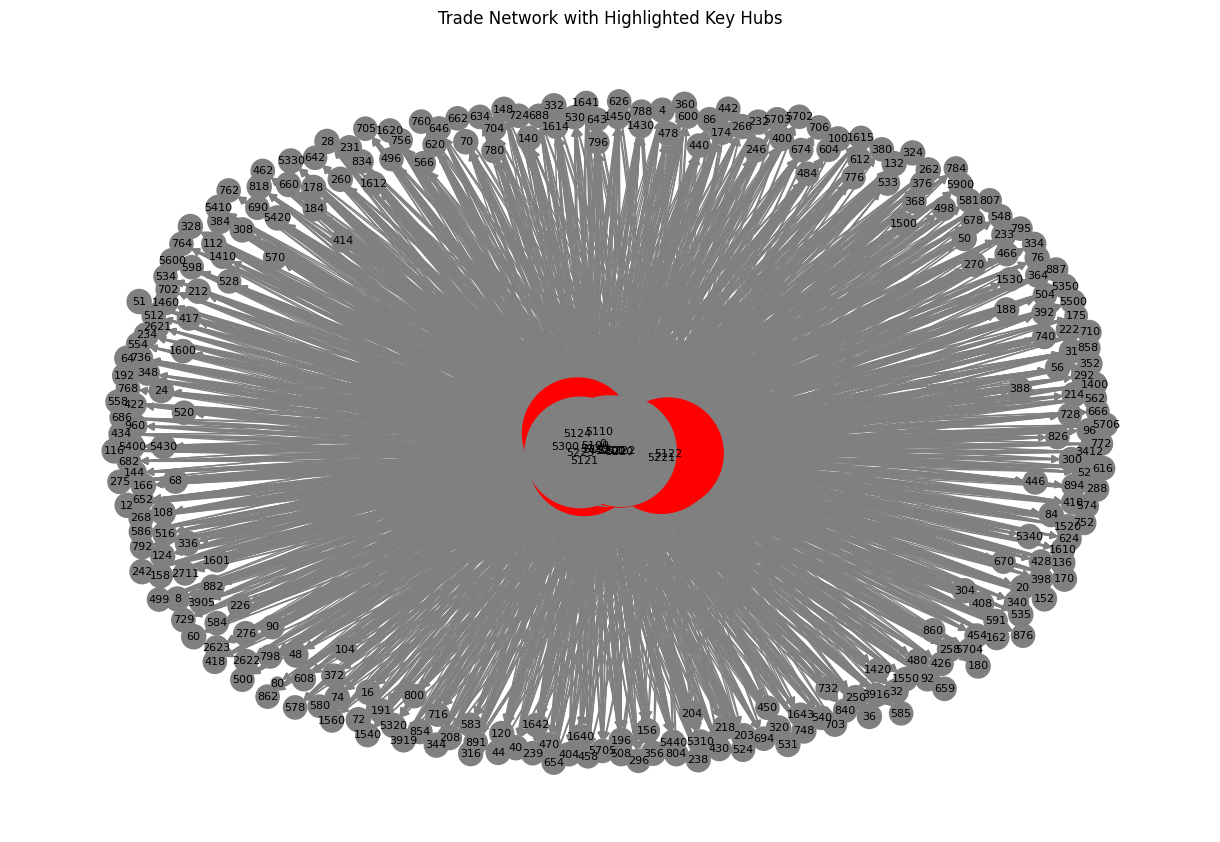

In [18]:
# Compute the layout for the graph
pos = nx.spring_layout(G, seed=42)  # Ensures all nodes have positions

# Identify the most connected nodes
degree_dict = dict(G.degree())
top_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]

# Print top trade hubs
print("🏆 Top 10 Trade Hubs (Most Connected Nodes):")
for node, degree in top_nodes:
    print(f"Node {node}: {degree} connections")

# Plot the network graph highlighting key hubs
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True,
        node_size=[degree_dict[n] * 20 for n in G.nodes()],
        node_color=["red" if n in dict(top_nodes) else "gray" for n in G.nodes()],
        edge_color="gray", font_size=8)

plt.title("Trade Network with Highlighted Key Hubs")
plt.show()

🔍 Number of Weakly Connected Components: 1


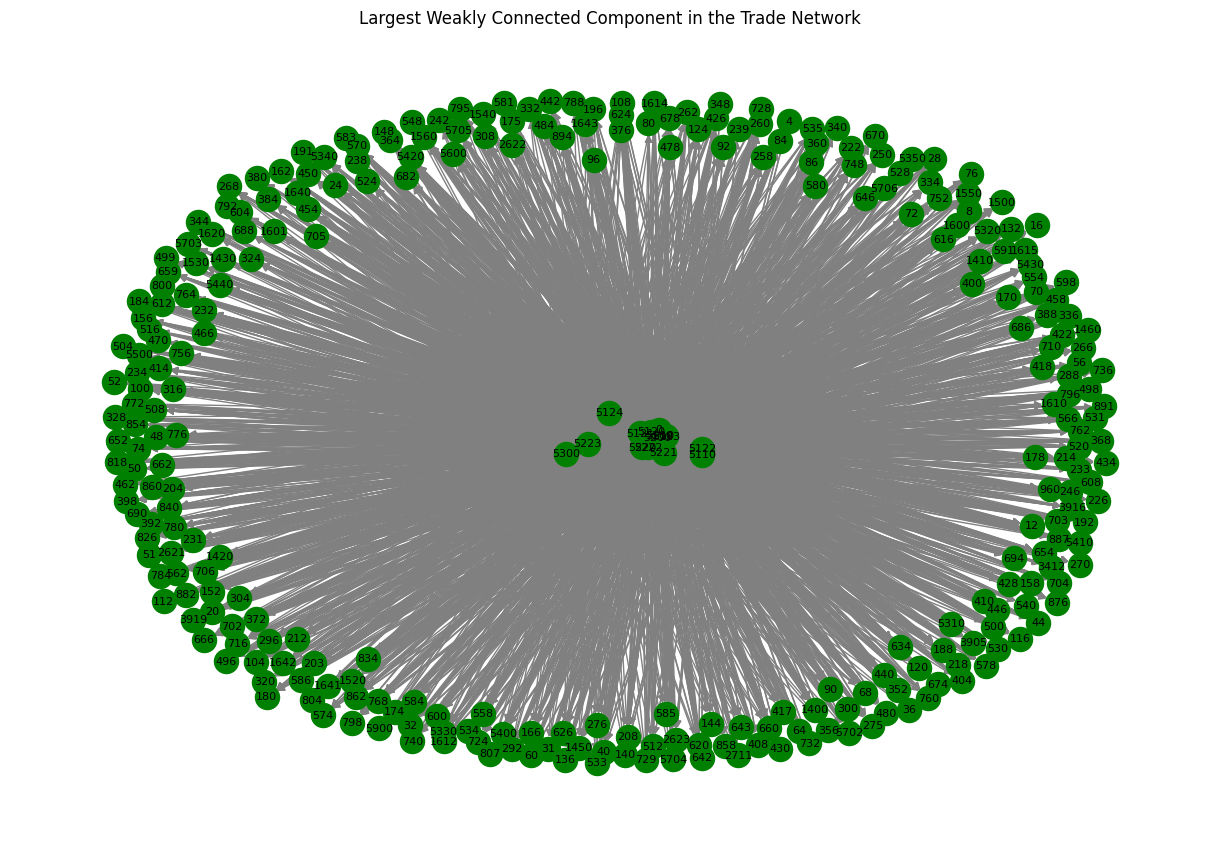

In [19]:
# Find and visualize weakly connected components (since the graph is directed)
components = list(nx.weakly_connected_components(G))
print(f"🔍 Number of Weakly Connected Components: {len(components)}")

# Extract the largest weakly connected component
largest_component = max(components, key=len)
G_largest = G.subgraph(largest_component).copy()  # Create a copy to avoid issues

# Visualize the Largest Weakly Connected Component
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_largest)  # Generate positions for visualization
nx.draw(G_largest, pos, with_labels=True, node_size=300, node_color="green", edge_color="gray", font_size=8)

plt.title("Largest Weakly Connected Component in the Trade Network")
plt.show()

In [20]:
# Compute PageRank
pagerank = nx.pagerank(G, alpha=0.85)
print("\U0001F4CA PageRank (Top 10 Influential Nodes):")
for node, pr in sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"Node {node}: {pr:.4f}")

# Compute Betweenness Centrality
betweenness = nx.betweenness_centrality(G)
print("\U0001F4C8 Betweenness Centrality (Top 10 Nodes):")
for node, bc in sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"Node {node}: {bc:.4f}")

# Compute Closeness Centrality
closeness = nx.closeness_centrality(G)
print("\U0001F50E Closeness Centrality (Top 10 Nodes):")
for node, cc in sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"Node {node}: {cc:.4f}")

# Compute Assortativity (Degree Assortativity Coefficient)
assortativity = nx.degree_assortativity_coefficient(G)
print(f"\U0001F50D Network Assortativity: {assortativity:.4f}")

📊 PageRank (Top 10 Influential Nodes):
Node 0: 0.0086
Node 3916: 0.0057
Node 1500: 0.0056
Node 3905: 0.0056
Node 5706: 0.0054
Node 5702: 0.0054
Node 5400: 0.0048
Node 1400: 0.0048
Node 5200: 0.0048
Node 1601: 0.0046
📈 Betweenness Centrality (Top 10 Nodes):
Node 0: 0.0002
Node 5200: 0.0002
Node 5220: 0.0002
Node 5222: 0.0002
Node 5100: 0.0001
Node 5120: 0.0001
Node 5122: 0.0001
Node 5221: 0.0001
Node 5223: 0.0001
Node 5121: 0.0001
🔎 Closeness Centrality (Top 10 Nodes):
Node 5310: 0.0497
Node 5330: 0.0497
Node 5350: 0.0497
Node 5320: 0.0497
Node 5340: 0.0497
Node 5400: 0.0497
Node 5410: 0.0497
Node 5420: 0.0497
Node 5430: 0.0497
Node 5440: 0.0497
🔍 Network Assortativity: -0.1594


Graph-Based Machine Learning for Trade Network Evolution Prediction

In [21]:
# Ensure the graph G is undirected if needed
if G.is_directed():
    G = G.to_undirected()
# Initialize DataFrame to store edge features
edge_features = pd.DataFrame(index=G.edges())

# -------------------------------
# 1️⃣ Preferential Attachment
# -------------------------------
preferential_attachment = list(nx.preferential_attachment(G))
for u, v, score in preferential_attachment:
    edge_features.loc[(u, v), "preferential_attachment"] = score

# -------------------------------
# 2️⃣ Katz Centrality
# -------------------------------
katz_centrality = nx.katz_centrality_numpy(G, alpha=0.01, beta=1.0)
katz_df = pd.DataFrame(katz_centrality.items(), columns=["Node", "Katz Centrality"])
katz_df = katz_df.sort_values(by="Katz Centrality", ascending=False)

# -------------------------------
# 3️⃣ HITS Algorithm (Hubs & Authorities)
# -------------------------------
hubs, authorities = nx.hits(G, max_iter=100, tol=1e-6)
hubs_df = pd.DataFrame(hubs.items(), columns=["Node", "Hub Score"]).sort_values(by="Hub Score", ascending=False)
authorities_df = pd.DataFrame(authorities.items(), columns=["Node", "Authority Score"]).sort_values(by="Authority Score", ascending=False)

# -------------------------------
# 4️⃣ Jaccard Coefficient (Node Similarity)
# -------------------------------
jaccard_coeff = list(nx.jaccard_coefficient(G))
for u, v, coeff in jaccard_coeff:
    edge_features.loc[(u, v), "jaccard_coefficient"] = coeff

# -------------------------------
# 5️⃣ Adamic-Adar Index (Trade Relationship Strength)
# -------------------------------
adamic_adar = list(nx.adamic_adar_index(G))
for u, v, score in adamic_adar:
    edge_features.loc[(u, v), "adamic_adar"] = score

# -------------------------------
# 6️⃣ Resource Allocation Index
# -------------------------------
resource_alloc = list(nx.resource_allocation_index(G))
for u, v, score in resource_alloc:
    edge_features.loc[(u, v), "resource_allocation"] = score

# -------------------------------
# 7️⃣ Network Assortativity (Degree Correlation)
# -------------------------------
assortativity = nx.degree_assortativity_coefficient(G)

# -------------------------------
# Results Display
# -------------------------------
print("\n📊 Preferential Attachment (Top 5):")
print(edge_features["preferential_attachment"].dropna().head())

print("\n📊 Katz Centrality (Top 10):")
print(katz_df.head(10))

print("\n📊 Hubs (Top 10):")
print(hubs_df.head(10))

print("\n📊 Authorities (Top 10):")
print(authorities_df.head(10))

print("\n📊 Jaccard Coefficient (Top 5):")
print(edge_features["jaccard_coefficient"].dropna().head())

print("\n📊 Adamic-Adar Index (Top 5):")
print(edge_features["adamic_adar"].dropna().head())

print("\n📊 Resource Allocation Index (Top 5):")
print(edge_features["resource_allocation"].dropna().head())

print("\n📊 Network Assortativity Coefficient:", round(assortativity, 4))


📊 Preferential Attachment (Top 5):
5120  80     1212.0
5121  80     1208.0
      666    3926.0
5122  80     1212.0
5123  80     1208.0
Name: preferential_attachment, dtype: float64

📊 Katz Centrality (Top 10):
    Node  Katz Centrality
0      0         0.173463
10  5220         0.173463
8   5200         0.173463
3   5120         0.173194
1   5100         0.173194
11  5221         0.173194
5   5122         0.173194
7   5124         0.172803
4   5121         0.172769
9   5210         0.172769

📊 Hubs (Top 10):
     Node  Hub Score
0       0   0.176381
276  1500   0.049286
300  3905   0.048874
266  5706   0.046240
265  5702   0.043898
8    5200   0.042164
298  3916   0.041697
9    5210   0.034320
20   5400   0.032643
281  1540   0.031547

📊 Authorities (Top 10):
     Node  Authority Score
0       0         0.176381
276  1500         0.049286
300  3905         0.048874
266  5706         0.046240
265  5702         0.043898
8    5200         0.042164
298  3916         0.041697
9    5210    

Temporal Network Analysis: How Has the Network Changed Over Time?

,degree_centrality_2007_2012,betweenness_centrality_2007_2012,pagerank_2007_2012,density_2007_2012,clustering_2007_2012,degree_centrality_2019_2023,betweenness_centrality_2019_2023,pagerank_2019_2023,density_2019_2023,clustering_2019_2023
5200,1.053333,0.0,0.004407,0.047907,0.001047,1.053156,0.0,0.004772,0.046468,0.001155
0,1.053333,0.0,0.008495,0.047907,0.001047,1.053156,0.0,0.008707,0.046468,0.001155
5220,1.053333,0.0,0.003565,0.047907,0.001047,1.053156,0.0,0.003688,0.046468,0.001155
5100,1.053333,0.0,0.003376,0.047907,0.001047,1.049834,0.0,0.003631,0.046468,0.001155
5120,1.053333,0.0,0.003354,0.047907,0.001047,1.049834,0.0,0.003587,0.046468,0.001155
...,...,...,...,...,...,...,...,...,...,...
535,0.050000,0.0,0.003160,0.047907,0.001047,0.036545,0.0,0.003144,0.046468,0.001155
580,0.043333,0.0,0.003159,0.047907,0.001047,0.036545,0.0,0.003144,0.046468,0.001155
728,0.046667,0.0,0.003160,0.047907,0.001047,0.033223,0.0,0.003144,0.046468,0.001155
334,0.043333,0.0,0.003159,0.047907,0.001047,0.033223,0.0,0.003144,0.046468,0.001155


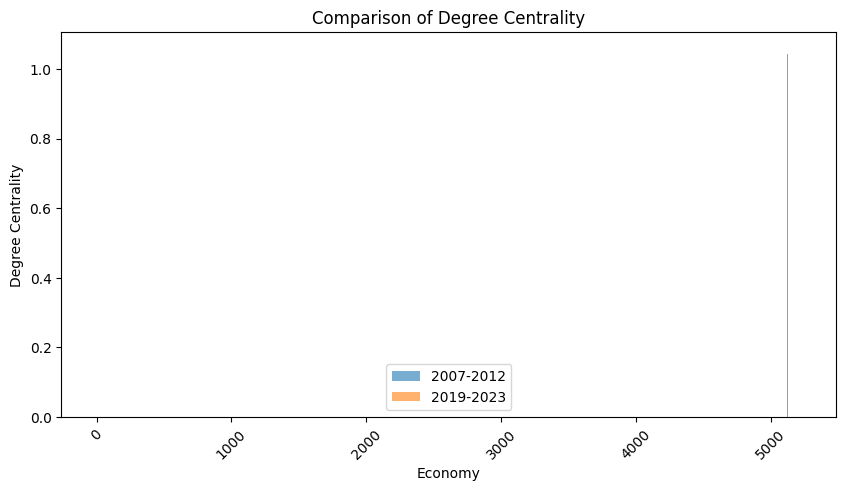

In [34]:
# Load preprocessed trade data for each period
trade_2007_2012 = trade_2007_2012_final  # Already cleaned & merged
trade_2019_2023 = trade_2019_2023_final  # Already cleaned & merged

# Create NetworkX graphs
G_2007_2012 = nx.DiGraph()
G_2019_2023 = nx.DiGraph()

# Add edges (trade flow between economies)
for _, row in trade_2007_2012.iterrows():
    G_2007_2012.add_edge(row['Economy'], row['Partner'], weight=row['US$ at current prices in thousands'])

for _, row in trade_2019_2023.iterrows():
    G_2019_2023.add_edge(row['Economy'], row['Partner'], weight=row['US$ at current prices in thousands'])

# Compute network metrics
metrics = ['degree_centrality', 'betweenness_centrality', 'pagerank', 'density', 'clustering']
network_metrics = {}

def compute_metrics(graph, name):
    network_metrics[name] = {
        'degree_centrality': nx.degree_centrality(graph),
        'betweenness_centrality': nx.betweenness_centrality(graph, weight='weight'),
        'pagerank': nx.pagerank(graph, weight='weight'),
        'density': nx.density(graph),
        'clustering': nx.average_clustering(graph, weight='weight')
    }

# Compute for both periods
compute_metrics(G_2007_2012, '2007-2012')
compute_metrics(G_2019_2023, '2019-2023')

# Convert to DataFrame for comparison
df_metrics_2007_2012 = pd.DataFrame(network_metrics['2007-2012'])
df_metrics_2019_2023 = pd.DataFrame(network_metrics['2019-2023'])

# Merge the metrics for comparison
df_comparison = df_metrics_2007_2012.join(df_metrics_2019_2023, lsuffix='_2007_2012', rsuffix='_2019_2023')

# Display results
df_comparison.sort_values(by='degree_centrality_2019_2023', ascending=False, inplace=True)

display(df_comparison)

# Plot comparison of Degree Centrality (Top 10 hubs)
def plot_metric(metric_name):
    top_10 = df_comparison.nlargest(10, f'{metric_name}_2019_2023')
    plt.figure(figsize=(10, 5))
    plt.bar(top_10.index, top_10[f'{metric_name}_2007_2012'], label='2007-2012', alpha=0.6)
    plt.bar(top_10.index, top_10[f'{metric_name}_2019_2023'], label='2019-2023', alpha=0.6)
    plt.xlabel('Economy')
    plt.ylabel(metric_name.replace('_', ' ').title())
    plt.legend()
    plt.title(f'Comparison of {metric_name.replace("_", " ").title()}')
    plt.xticks(rotation=45)
    plt.show()

# Plot Degree Centrality Comparison
plot_metric('degree_centrality')

/tmp/ipykernel_1029788/2714692963.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['degree_centrality_2007_2012'] /= df_filtered['degree_centrality_2007_2012'].max()
/tmp/ipykernel_1029788/2714692963.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['degree_centrality_2019_2023'] /= df_filtered['degree_centrality_2019_2023'].max()


,degree_centrality_2007_2012,betweenness_centrality_2007_2012,pagerank_2007_2012,density_2007_2012,clustering_2007_2012,degree_centrality_2019_2023,betweenness_centrality_2019_2023,pagerank_2019_2023,density_2019_2023,clustering_2019_2023
64,1.000000,0.0,0.003162,0.047907,0.001047,1.000000,0.0,0.003144,0.046468,0.001155
68,1.000000,0.0,0.003159,0.047907,0.001047,1.000000,0.0,0.003147,0.046468,0.001155
8,1.000000,0.0,0.003159,0.047907,0.001047,1.000000,0.0,0.003145,0.046468,0.001155
12,1.000000,0.0,0.003167,0.047907,0.001047,1.000000,0.0,0.003146,0.046468,0.001155
16,1.000000,0.0,0.003159,0.047907,0.001047,1.000000,0.0,0.003144,0.046468,0.001155
...,...,...,...,...,...,...,...,...,...,...
666,0.800000,0.0,0.003159,0.047907,0.001047,0.733333,0.0,0.003144,0.046468,0.001155
535,1.000000,0.0,0.003160,0.047907,0.001047,0.733333,0.0,0.003144,0.046468,0.001155
580,0.866667,0.0,0.003159,0.047907,0.001047,0.733333,0.0,0.003144,0.046468,0.001155
728,0.933333,0.0,0.003160,0.047907,0.001047,0.666667,0.0,0.003144,0.046468,0.001155


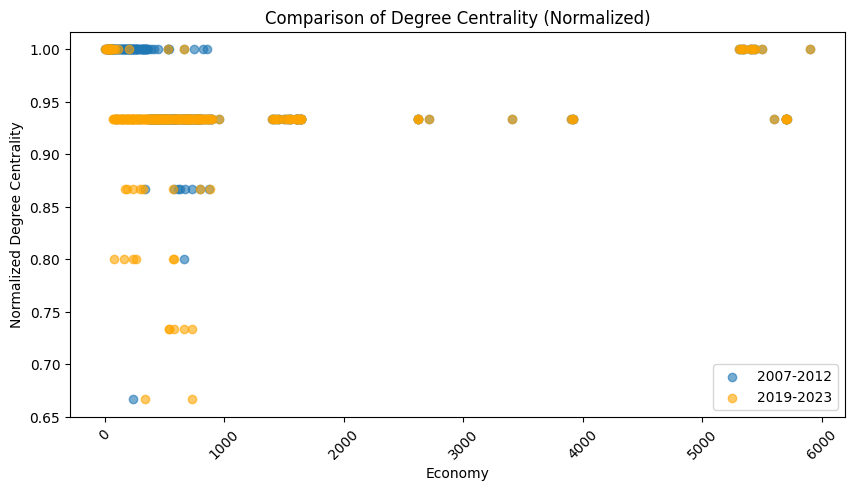

In [37]:
# Remove extreme outliers (above 95th percentile)
threshold_2007_2012 = df_comparison['degree_centrality_2007_2012'].quantile(0.95)
threshold_2019_2023 = df_comparison['degree_centrality_2019_2023'].quantile(0.95)
df_filtered = df_comparison[(df_comparison['degree_centrality_2007_2012'] <= threshold_2007_2012) &
                             (df_comparison['degree_centrality_2019_2023'] <= threshold_2019_2023)]

# Normalize values between 0 and 1
df_filtered['degree_centrality_2007_2012'] /= df_filtered['degree_centrality_2007_2012'].max()
df_filtered['degree_centrality_2019_2023'] /= df_filtered['degree_centrality_2019_2023'].max()

# Display results
display(df_filtered)

# Scatter plot for better visualization
def plot_scatter(metric_name):
    plt.figure(figsize=(10, 5))
    plt.scatter(df_filtered.index, df_filtered[f'{metric_name}_2007_2012'], label='2007-2012', alpha=0.6)
    plt.scatter(df_filtered.index, df_filtered[f'{metric_name}_2019_2023'], label='2019-2023', alpha=0.6, color='orange')
    plt.xlabel('Economy')
    plt.ylabel(f'Normalized {metric_name.replace("_", " ").title()}')
    plt.legend()
    plt.title(f'Comparison of {metric_name.replace("_", " ").title()} (Normalized)')
    plt.xticks(rotation=45)
    plt.show()

# Plot Degree Centrality Comparison with Scatter Plot
plot_scatter('degree_centrality')

Top 10 Trade Hubs with the Largest Gain in Degree Centrality


,degree_centrality_2007_2012,degree_centrality_2019_2023,degree_centrality_change
239,0.033333,0.039867,0.006534
5223,1.040000,1.046512,0.006512
612,0.043333,0.046512,0.003178
674,0.043333,0.046512,0.003178
876,0.043333,0.046512,0.003178
626,0.043333,0.046512,0.003178
798,0.043333,0.043189,-0.000144
5123,1.043333,1.043189,-0.000144
5121,1.046667,1.046512,-0.000155
5210,1.046667,1.046512,-0.000155


Top 10 Trade Hubs with the Largest Drop in Degree Centrality


,degree_centrality_2007_2012,degree_centrality_2019_2023,degree_centrality_change
5300,0.486667,0.222591,-0.264075
5122,1.050000,1.006645,-0.043355
5110,1.043333,1.000000,-0.043333
5124,1.050000,1.026578,-0.023422
535,0.050000,0.036545,-0.013455
728,0.046667,0.033223,-0.013444
260,0.050000,0.039867,-0.010133
162,0.050000,0.039867,-0.010133
74,0.050000,0.039867,-0.010133
534,0.046667,0.036545,-0.010122


Top 10 Trade Hubs with the Largest Gain in Betweenness Centrality


,betweenness_centrality_2007_2012,betweenness_centrality_2019_2023,betweenness_centrality_change
5122,0.012308,0.016755,0.004448
5221,0.013322,0.014718,0.001395
5110,0.000323,0.000930,0.000607
5223,0.000011,0.000155,0.000144
5222,0.000000,0.000122,0.000122
5123,0.000535,0.000620,0.000085
5200,0.000000,0.000000,0.000000
0,0.000000,0.000000,0.000000
5220,0.000000,0.000000,0.000000
5100,0.000000,0.000000,0.000000


Top 10 Trade Hubs with the Largest Drop in Betweenness Centrality


,betweenness_centrality_2007_2012,betweenness_centrality_2019_2023,betweenness_centrality_change
5121,0.004136,0.000952,-0.003184
5124,0.001315,0.000941,-0.000374
5200,0.000000,0.000000,0.000000
0,0.000000,0.000000,0.000000
5220,0.000000,0.000000,0.000000
5100,0.000000,0.000000,0.000000
5120,0.000000,0.000000,0.000000
5210,0.000000,0.000000,0.000000
5300,0.000000,0.000000,0.000000
64,0.000000,0.000000,0.000000


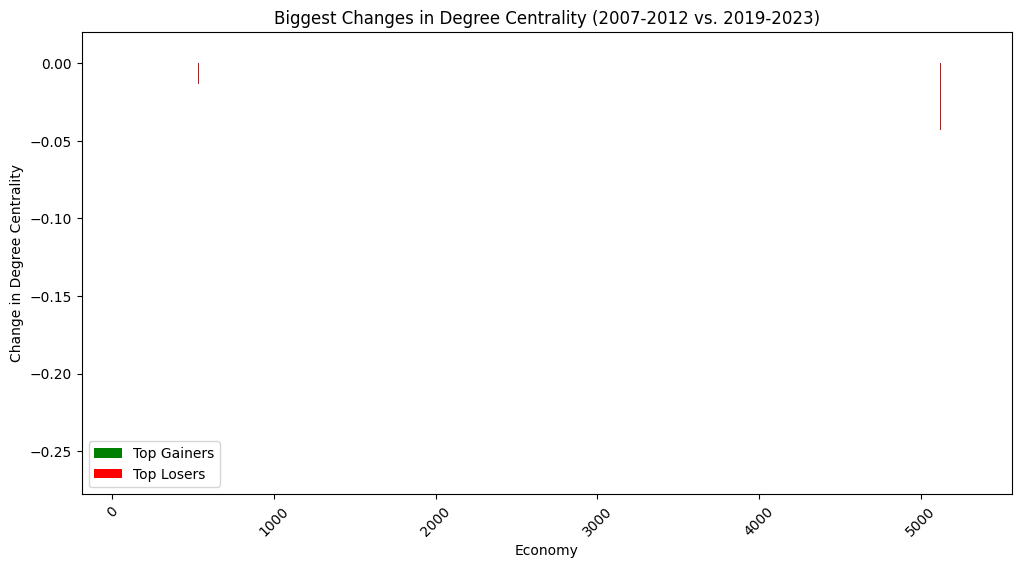

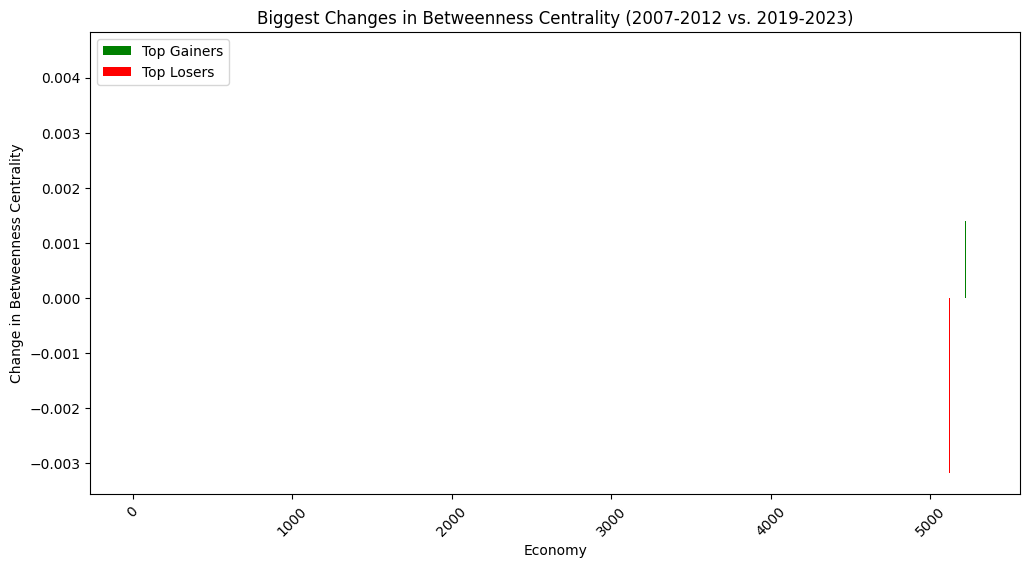

In [39]:
# Compute absolute change in centrality for degree and betweenness
for metric in ['degree_centrality', 'betweenness_centrality']:
    df_comparison[f'{metric}_change'] = df_comparison[f'{metric}_2019_2023'] - df_comparison[f'{metric}_2007_2012']

# Identify the top 10 economies with the largest change (increase or decrease)
top_gainers_degree = df_comparison.nlargest(10, 'degree_centrality_change')
top_losers_degree = df_comparison.nsmallest(10, 'degree_centrality_change')

top_gainers_betweenness = df_comparison.nlargest(10, 'betweenness_centrality_change')
top_losers_betweenness = df_comparison.nsmallest(10, 'betweenness_centrality_change')

# Display results
print("Top 10 Trade Hubs with the Largest Gain in Degree Centrality")
display(top_gainers_degree[['degree_centrality_2007_2012', 'degree_centrality_2019_2023', 'degree_centrality_change']])

print("Top 10 Trade Hubs with the Largest Drop in Degree Centrality")
display(top_losers_degree[['degree_centrality_2007_2012', 'degree_centrality_2019_2023', 'degree_centrality_change']])

print("Top 10 Trade Hubs with the Largest Gain in Betweenness Centrality")
display(top_gainers_betweenness[['betweenness_centrality_2007_2012', 'betweenness_centrality_2019_2023', 'betweenness_centrality_change']])

print("Top 10 Trade Hubs with the Largest Drop in Betweenness Centrality")
display(top_losers_betweenness[['betweenness_centrality_2007_2012', 'betweenness_centrality_2019_2023', 'betweenness_centrality_change']])

# Plot the changes in connectivity
def plot_top_changes(metric, top_gainers, top_losers):
    plt.figure(figsize=(12, 6))
    plt.bar(top_gainers.index, top_gainers[f'{metric}_change'], label='Top Gainers', color='green')
    plt.bar(top_losers.index, top_losers[f'{metric}_change'], label='Top Losers', color='red')
    plt.xlabel('Economy')
    plt.ylabel(f'Change in {metric.replace("_", " ").title()}')
    plt.legend()
    plt.title(f'Biggest Changes in {metric.replace("_", " ").title()} (2007-2012 vs. 2019-2023)')
    plt.xticks(rotation=45)
    plt.show()

# Plot results
plot_top_changes('degree_centrality', top_gainers_degree, top_losers_degree)
plot_top_changes('betweenness_centrality', top_gainers_betweenness, top_losers_betweenness)

forecasting model

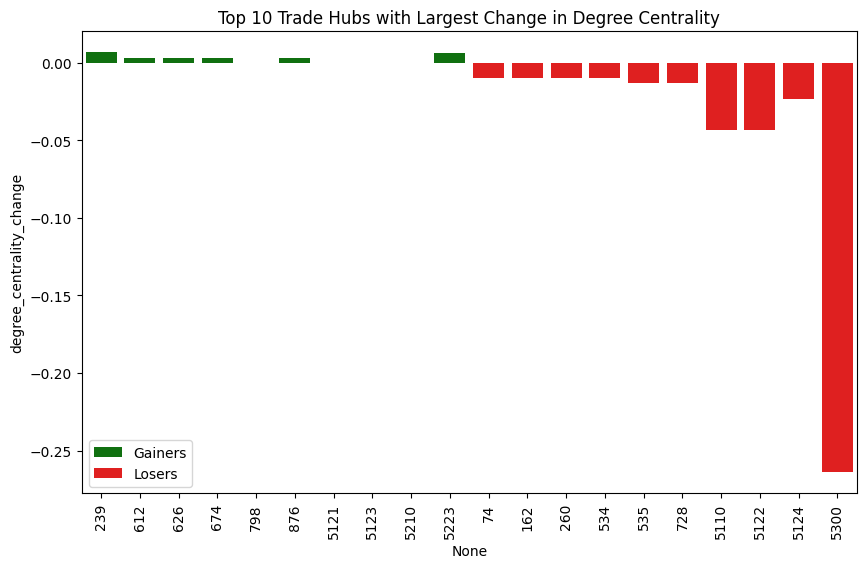

Ridge: R²=1.0000, MSE=0.000001, MAE=0.000349, CV Scores=[-0.30129902  0.98570944  0.99497241  0.997748    0.40084343]
RandomForest: R²=0.9999, MSE=0.000003, MAE=0.000425, CV Scores=[ -0.32622023   0.57953354   0.89445747   0.78775239 -21.3692637 ]
XGBoost: R²=0.9997, MSE=0.000012, MAE=0.000638, CV Scores=[-0.32695696  0.77480434  0.95402072  0.78246483  0.91032339]
NeuralNetwork: R²=0.1356, MSE=0.039444, MAE=0.044155, CV Scores=[ -10.72944513 -146.01172013  -14.49370786   -1.36823373  -95.91641511]
Best Model: Ridge


In [56]:
# Load preprocessed trade data for each period
trade_2007_2012 = trade_2007_2012_final  # Already cleaned & merged
trade_2019_2023 = trade_2019_2023_final  # Already cleaned & merged

# Create NetworkX graphs
G_2007_2012 = nx.DiGraph()
G_2019_2023 = nx.DiGraph()

# Add edges (trade flow between economies)
for _, row in trade_2007_2012.iterrows():
    G_2007_2012.add_edge(row['Economy'], row['Partner'], weight=row['US$ at current prices in thousands'])

for _, row in trade_2019_2023.iterrows():
    G_2019_2023.add_edge(row['Economy'], row['Partner'], weight=row['US$ at current prices in thousands'])

# Compute network metrics
network_metrics = {}

def compute_metrics(graph, name):
    network_metrics[name] = {
        'degree_centrality': nx.degree_centrality(graph),
        'betweenness_centrality': nx.betweenness_centrality(graph, weight='weight'),
        'pagerank': nx.pagerank(graph, weight='weight'),
        'density': nx.density(graph),
        'clustering': nx.average_clustering(graph, weight='weight')
    }

# Compute for both periods
compute_metrics(G_2007_2012, '2007-2012')
compute_metrics(G_2019_2023, '2019-2023')

# Convert to DataFrame for comparison
df_metrics_2007_2012 = pd.DataFrame(network_metrics['2007-2012'])
df_metrics_2019_2023 = pd.DataFrame(network_metrics['2019-2023'])

# Merge the metrics for comparison
df_comparison = df_metrics_2007_2012.join(df_metrics_2019_2023, lsuffix='_2007_2012', rsuffix='_2019_2023')

# Compute absolute change in centrality for degree and betweenness
for metric in ['degree_centrality', 'betweenness_centrality']:
    df_comparison[f'{metric}_change'] = df_comparison[f'{metric}_2019_2023'] - df_comparison[f'{metric}_2007_2012']

# Identify the top 10 economies with the largest change (increase or decrease)
top_gainers_degree = df_comparison.nlargest(10, 'degree_centrality_change')
top_losers_degree = df_comparison.nsmallest(10, 'degree_centrality_change')

top_gainers_betweenness = df_comparison.nlargest(10, 'betweenness_centrality_change')
top_losers_betweenness = df_comparison.nsmallest(10, 'betweenness_centrality_change')

# Visualize top changes
plt.figure(figsize=(10, 6))
sns.barplot(x=top_gainers_degree.index, y=top_gainers_degree['degree_centrality_change'], color='green', label='Gainers')
sns.barplot(x=top_losers_degree.index, y=top_losers_degree['degree_centrality_change'], color='red', label='Losers')
plt.title('Top 10 Trade Hubs with Largest Change in Degree Centrality')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Prepare data for forecasting
features = ['degree_centrality_2007_2012', 'betweenness_centrality_2007_2012', 'pagerank_2007_2012', 'density_2007_2012', 'clustering_2007_2012']
target = 'degree_centrality_2019_2023'

# Additional features
features.append('degree_centrality_change')
features.append('betweenness_centrality_change')

# Handle NaN and Infinite values
df_comparison.replace([np.inf, -np.inf], np.nan, inplace=True)
df_comparison.dropna(inplace=True)

# Normalize the features
scaler = StandardScaler()
df_comparison[features] = scaler.fit_transform(df_comparison[features])

X = df_comparison[features]
y = df_comparison[target]

# Model selection and comparison
models = {
    'Ridge': Ridge(),
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'NeuralNetwork': MLPRegressor(max_iter=500)
}

results = {}
for name, model in models.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    
    results[name] = {
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'CV Scores': cv_scores
    }
    
    print(f'{name}: R²={r2:.4f}, MSE={mse:.6f}, MAE={mae:.6f}, CV Scores={cv_scores}')

# Select the best model
best_model_name = max(results, key=lambda k: results[k]['R²'])
best_model = models[best_model_name]

print(f'Best Model: {best_model_name}')

# Predict future degree centrality for 2025
df_comparison['predicted_degree_centrality_2025'] = best_model.predict(X)

# Visualize feature importance
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=features, y=best_model.feature_importances_)
    plt.xticks(rotation=90)
    plt.title('Feature Importance in Predicting Degree Centrality')
    plt.show()

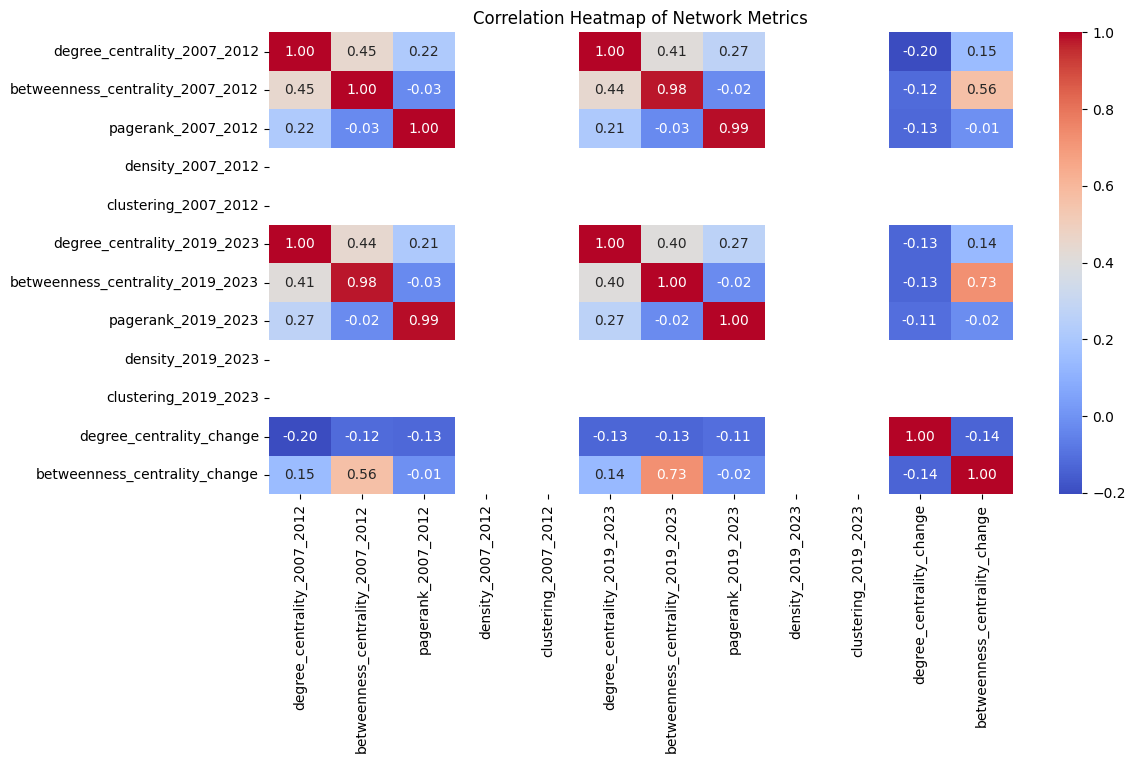

Best Ridge Alpha: {'alpha': 0.01}
Ridge: R²=1.0000, MSE=0.000000, MAE=0.000004, CV Scores=[0.76641737 0.99999856 0.99999949 0.99999977 0.99993836]
RandomForest: R²=0.9999, MSE=0.000005, MAE=0.000473, CV Scores=[ -0.32642092   0.59112195   0.88571263   0.77852572 -46.77313014]
XGBoost: R²=0.9997, MSE=0.000012, MAE=0.000638, CV Scores=[-0.32695696  0.77480434  0.95402072  0.78246483  0.91032339]
NeuralNetwork: R²=0.3890, MSE=0.027880, MAE=0.042422, CV Scores=[  -6.89492387  -87.31858913  -25.37776638  -15.24920694 -778.91723196]
Best Model: Ridge


In [60]:
# Compute network metrics
def compute_metrics(graph):
    return {
        'degree_centrality': nx.degree_centrality(graph),
        'betweenness_centrality': nx.betweenness_centrality(graph, weight='weight'),
        'pagerank': nx.pagerank(graph, weight='weight'),
        'density': nx.density(graph),
        'clustering': nx.average_clustering(graph, weight='weight')
    }

# Compute for both periods
metrics_2007_2012 = compute_metrics(G_2007_2012)
metrics_2019_2023 = compute_metrics(G_2019_2023)

# Convert to DataFrame
df_metrics_2007_2012 = pd.DataFrame(metrics_2007_2012)
df_metrics_2019_2023 = pd.DataFrame(metrics_2019_2023)

# Merge the metrics for comparison
df_comparison = df_metrics_2007_2012.join(df_metrics_2019_2023, lsuffix='_2007_2012', rsuffix='_2019_2023')

# Compute absolute change in centrality
df_comparison['degree_centrality_change'] = df_comparison['degree_centrality_2019_2023'] - df_comparison['degree_centrality_2007_2012']
df_comparison['betweenness_centrality_change'] = df_comparison['betweenness_centrality_2019_2023'] - df_comparison['betweenness_centrality_2007_2012']

# Identify top gainers and losers
top_gainers = df_comparison.nlargest(10, 'degree_centrality_change')
top_losers = df_comparison.nsmallest(10, 'degree_centrality_change')

# Ensure data integrity
df_comparison.replace([np.inf, -np.inf], np.nan, inplace=True)
df_comparison.dropna(inplace=True)

# Enhanced visualization
plt.figure(figsize=(12, 6))
sns.heatmap(df_comparison.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Network Metrics')
plt.show()

# Normalize the features
features = ['degree_centrality_2007_2012', 'betweenness_centrality_2007_2012', 'pagerank_2007_2012', 'density_2007_2012', 'clustering_2007_2012',
            'degree_centrality_change', 'betweenness_centrality_change']
target = 'degree_centrality_2019_2023'

scaler = StandardScaler()
df_comparison[features] = scaler.fit_transform(df_comparison[features])
X = df_comparison[features]
y = df_comparison[target]

# Hyperparameter tuning for Ridge
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
grid.fit(X, y)
best_ridge_alpha = grid.best_params_
print(f"Best Ridge Alpha: {best_ridge_alpha}")

# Model selection
models = {
    'Ridge': Ridge(alpha=best_ridge_alpha['alpha']),
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'NeuralNetwork': MLPRegressor(max_iter=500)
}

results = {}
for name, model in models.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    results[name] = {'R²': r2, 'MSE': mse, 'MAE': mae, 'CV Scores': cv_scores}
    print(f'{name}: R²={r2:.4f}, MSE={mse:.6f}, MAE={mae:.6f}, CV Scores={cv_scores}')

# Select the best model
best_model_name = max(results, key=lambda k: results[k]['R²'])
best_model = models[best_model_name]
print(f'Best Model: {best_model_name}')

df_comparison['predicted_degree_centrality_2025'] = best_model.predict(X)


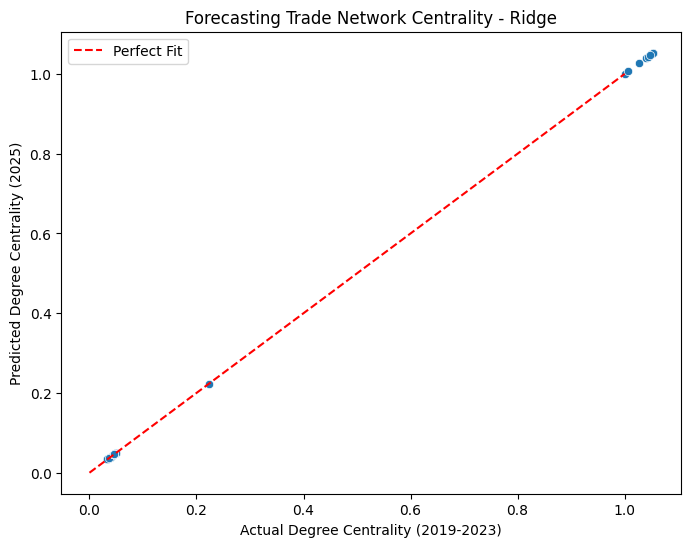

In [61]:
# Enhanced visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_comparison['degree_centrality_2019_2023'], y=df_comparison['predicted_degree_centrality_2025'])
plt.plot([0, 1], [0, 1], '--r', label='Perfect Fit')
plt.xlabel('Actual Degree Centrality (2019-2023)')
plt.ylabel('Predicted Degree Centrality (2025)')
plt.title(f'Forecasting Trade Network Centrality - {best_model_name}')
plt.legend()
plt.show()

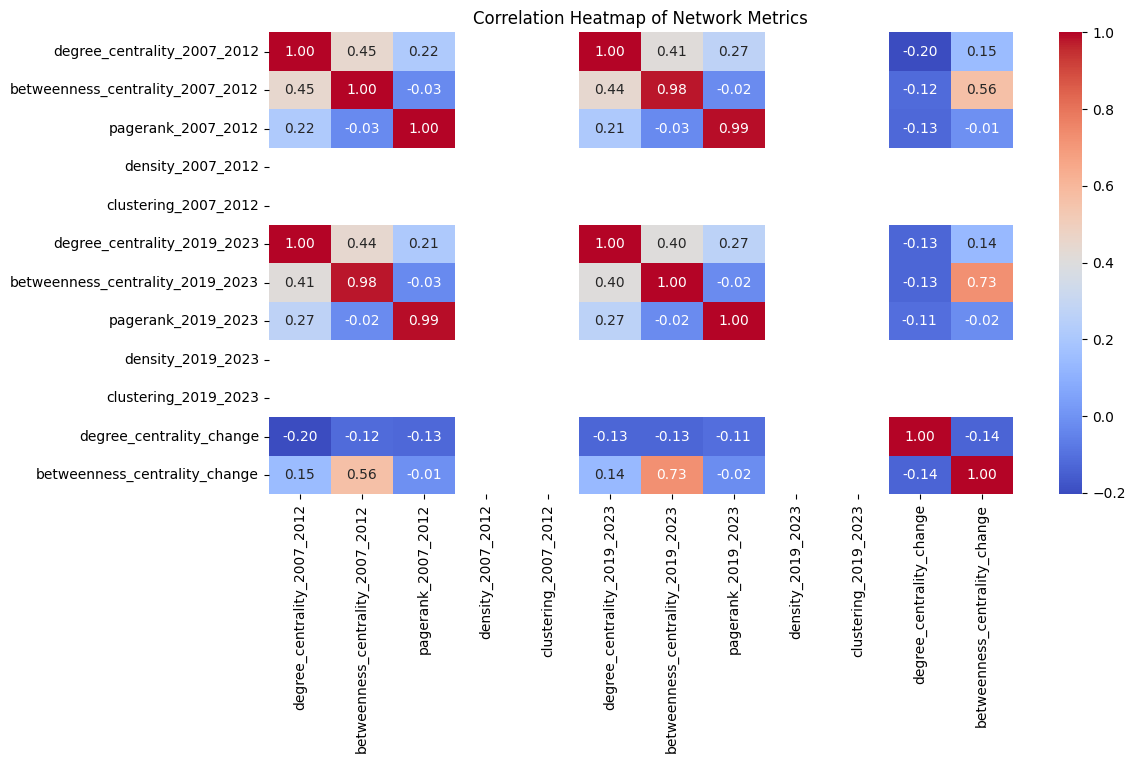

Best Ridge Alpha: {'alpha': 0.01}
Ridge: R²=1.0000, MSE=0.000000, MAE=0.000004, CV Scores=[0.76641737 0.99999856 0.99999949 0.99999977 0.99993836]
RandomForest: R²=0.9999, MSE=0.000006, MAE=0.000563, CV Scores=[ -0.32636389   0.51702744   0.87868208   0.77894076 -46.40174658]
XGBoost: R²=0.9997, MSE=0.000012, MAE=0.000638, CV Scores=[-0.32695696  0.77480434  0.95402072  0.78246483  0.91032339]
NeuralNetwork: R²=0.9910, MSE=0.000412, MAE=0.012287, CV Scores=[-5.91940555e+00 -1.77457015e+01 -7.79353652e-02 -2.45241754e+00
 -7.22674660e+02]
Best Model: Ridge


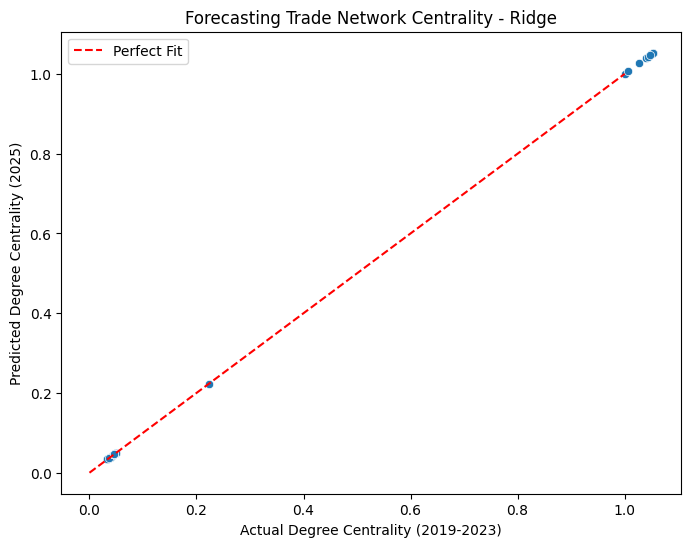

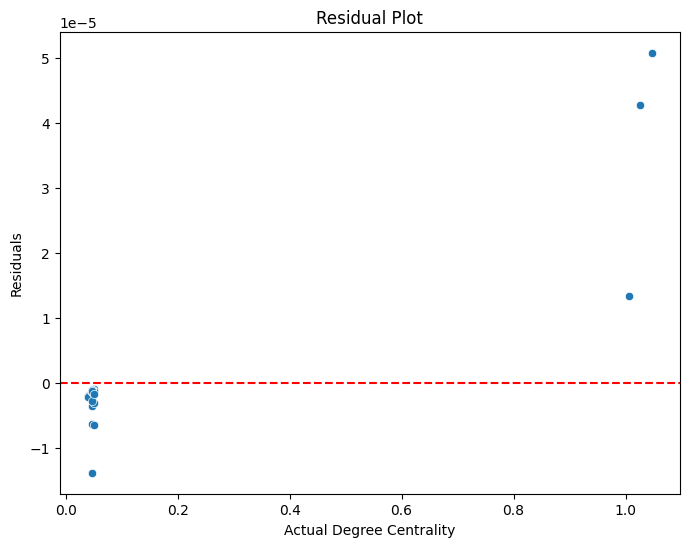

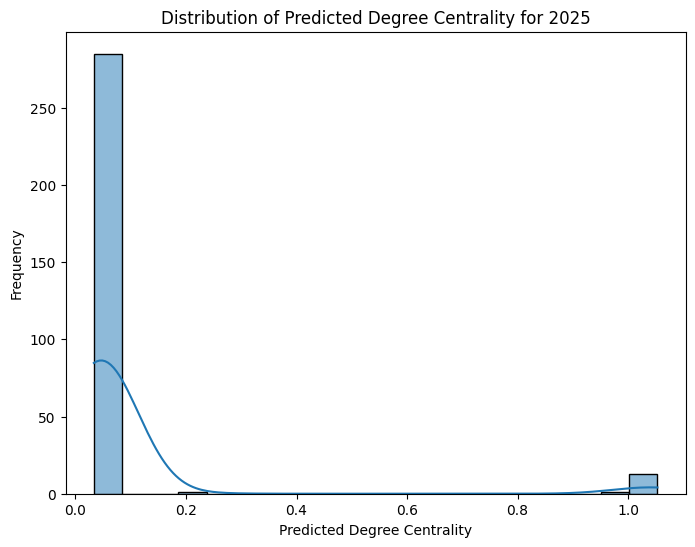

In [63]:
# Compute network metrics
def compute_metrics(graph):
    return {
        'degree_centrality': nx.degree_centrality(graph),
        'betweenness_centrality': nx.betweenness_centrality(graph, weight='weight'),
        'pagerank': nx.pagerank(graph, weight='weight'),
        'density': nx.density(graph),
        'clustering': nx.average_clustering(graph, weight='weight')
    }

# Compute for both periods
metrics_2007_2012 = compute_metrics(G_2007_2012)
metrics_2019_2023 = compute_metrics(G_2019_2023)

# Convert to DataFrame
df_metrics_2007_2012 = pd.DataFrame(metrics_2007_2012)
df_metrics_2019_2023 = pd.DataFrame(metrics_2019_2023)

# Merge the metrics for comparison
df_comparison = df_metrics_2007_2012.join(df_metrics_2019_2023, lsuffix='_2007_2012', rsuffix='_2019_2023')

# Compute absolute change in centrality
df_comparison['degree_centrality_change'] = df_comparison['degree_centrality_2019_2023'] - df_comparison['degree_centrality_2007_2012']
df_comparison['betweenness_centrality_change'] = df_comparison['betweenness_centrality_2019_2023'] - df_comparison['betweenness_centrality_2007_2012']

# Identify top gainers and losers
top_gainers = df_comparison.nlargest(10, 'degree_centrality_change')
top_losers = df_comparison.nsmallest(10, 'degree_centrality_change')

# Ensure data integrity
df_comparison.replace([np.inf, -np.inf], np.nan, inplace=True)
df_comparison.dropna(inplace=True)

# Enhanced visualization
plt.figure(figsize=(12, 6))
sns.heatmap(df_comparison.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Network Metrics')
plt.show()

# Normalize the features
features = ['degree_centrality_2007_2012', 'betweenness_centrality_2007_2012', 'pagerank_2007_2012', 'density_2007_2012', 'clustering_2007_2012',
            'degree_centrality_change', 'betweenness_centrality_change']
target = 'degree_centrality_2019_2023'

scaler = StandardScaler()
df_comparison[features] = scaler.fit_transform(df_comparison[features])
X = df_comparison[features]
y = df_comparison[target]

# Hyperparameter tuning for Ridge
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
grid.fit(X, y)
best_ridge_alpha = grid.best_params_
print(f"Best Ridge Alpha: {best_ridge_alpha}")

# Model selection
models = {
    'Ridge': Ridge(alpha=best_ridge_alpha['alpha']),
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'NeuralNetwork': MLPRegressor(max_iter=500)
}

results = {}
for name, model in models.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    results[name] = {'R²': r2, 'MSE': mse, 'MAE': mae, 'CV Scores': cv_scores}
    print(f'{name}: R²={r2:.4f}, MSE={mse:.6f}, MAE={mae:.6f}, CV Scores={cv_scores}')

# Select the best model
best_model_name = max(results, key=lambda k: results[k]['R²'])
best_model = models[best_model_name]
print(f'Best Model: {best_model_name}')

df_comparison['predicted_degree_centrality_2025'] = best_model.predict(X)

# Enhanced visualization: Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_comparison['degree_centrality_2019_2023'], y=df_comparison['predicted_degree_centrality_2025'])
plt.plot([0, 1], [0, 1], '--r', label='Perfect Fit')
plt.xlabel('Actual Degree Centrality (2019-2023)')
plt.ylabel('Predicted Degree Centrality (2025)')
plt.title(f'Forecasting Trade Network Centrality - {best_model_name}')
plt.legend()
plt.show()

# Feature importance visualization
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=features, y=best_model.feature_importances_)
    plt.xticks(rotation=90)
    plt.title('Feature Importance in Predicting Degree Centrality')
    plt.show()

# Residual plot
residuals = y_test - best_model.predict(X_test)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Degree Centrality')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Distribution of predicted values
plt.figure(figsize=(8, 6))
sns.histplot(df_comparison['predicted_degree_centrality_2025'], bins=20, kde=True)
plt.title('Distribution of Predicted Degree Centrality for 2025')
plt.xlabel('Predicted Degree Centrality')
plt.ylabel('Frequency')
plt.show()

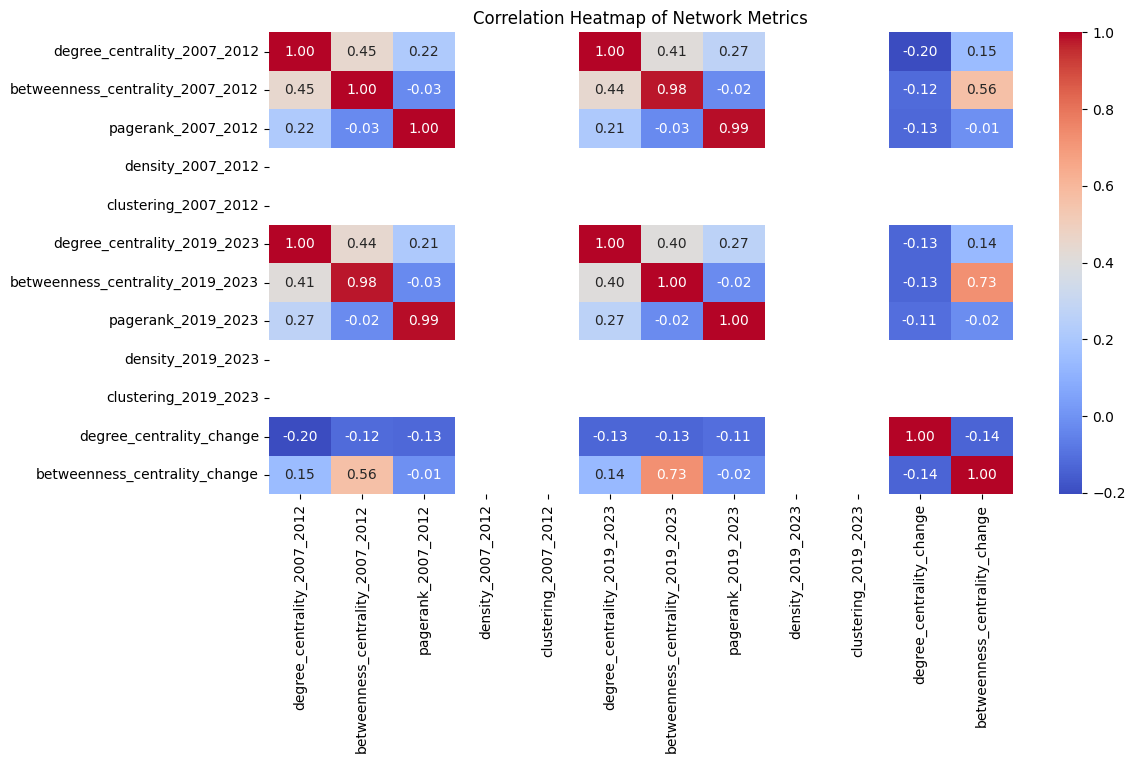

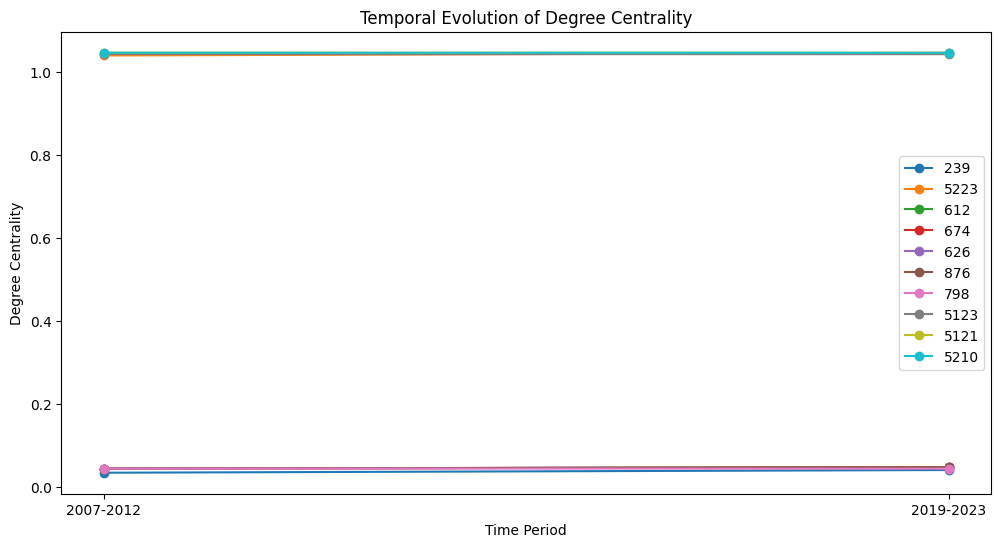

Best Ridge Alpha: {'alpha': 0.01}
Ridge: R²=1.0000, MSE=0.000000, MAE=0.000004, CV Scores=[0.76641737 0.99999856 0.99999949 0.99999977 0.99993836]
RandomForest: R²=0.9999, MSE=0.000003, MAE=0.000426, CV Scores=[ -0.32629811   0.59253963   0.89630553   0.77824051 -40.85165411]
XGBoost: R²=0.9997, MSE=0.000012, MAE=0.000638, CV Scores=[-0.32695696  0.77480434  0.95402072  0.78246483  0.91032339]
NeuralNetwork: R²=0.4855, MSE=0.023478, MAE=0.033589, CV Scores=[ 7.36549739e-01 -4.18859905e+01 -1.96554626e+01 -6.88005546e-02
 -1.28485705e+02]
Best Model: Ridge


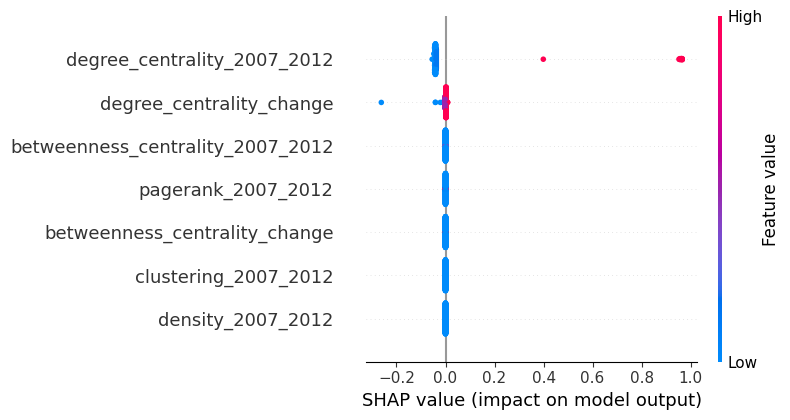

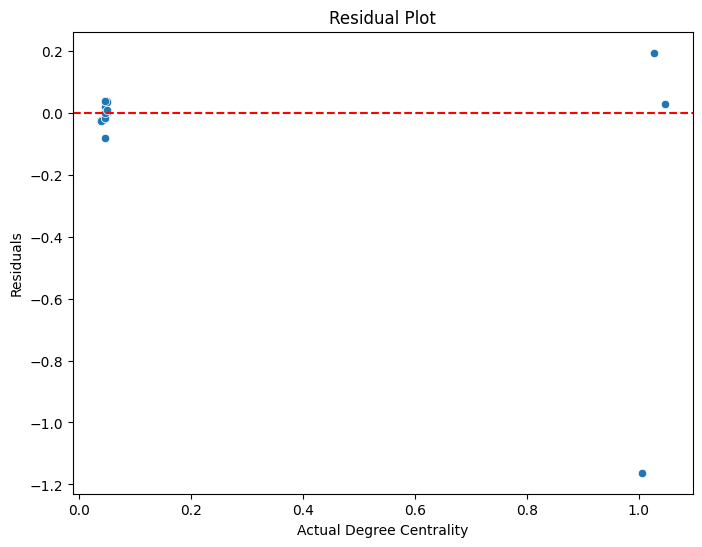

In [65]:
# Compute network metrics
def compute_metrics(graph):
    return {
        'degree_centrality': nx.degree_centrality(graph),
        'betweenness_centrality': nx.betweenness_centrality(graph, weight='weight'),
        'pagerank': nx.pagerank(graph, weight='weight'),
        'density': nx.density(graph),
        'clustering': nx.average_clustering(graph, weight='weight')
    }

# Compute for both periods
metrics_2007_2012 = compute_metrics(G_2007_2012)
metrics_2019_2023 = compute_metrics(G_2019_2023)

# Convert to DataFrame
df_metrics_2007_2012 = pd.DataFrame(metrics_2007_2012)
df_metrics_2019_2023 = pd.DataFrame(metrics_2019_2023)

# Merge the metrics for comparison
df_comparison = df_metrics_2007_2012.join(df_metrics_2019_2023, lsuffix='_2007_2012', rsuffix='_2019_2023')

# Compute absolute change in centrality
df_comparison['degree_centrality_change'] = df_comparison['degree_centrality_2019_2023'] - df_comparison['degree_centrality_2007_2012']
df_comparison['betweenness_centrality_change'] = df_comparison['betweenness_centrality_2019_2023'] - df_comparison['betweenness_centrality_2007_2012']

# Identify top gainers and losers
top_gainers = df_comparison.nlargest(10, 'degree_centrality_change')
top_losers = df_comparison.nsmallest(10, 'degree_centrality_change')

# Ensure data integrity
df_comparison.replace([np.inf, -np.inf], np.nan, inplace=True)
df_comparison.dropna(inplace=True)

# Enhanced visualization
plt.figure(figsize=(12, 6))
sns.heatmap(df_comparison.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Network Metrics')
plt.show()

# Temporal evolution of centrality
plt.figure(figsize=(12, 6))
for country in top_gainers.index:
    plt.plot(['2007-2012', '2019-2023'], [df_metrics_2007_2012.loc[country, 'degree_centrality'], df_metrics_2019_2023.loc[country, 'degree_centrality']], marker='o', label=country)
plt.xlabel('Time Period')
plt.ylabel('Degree Centrality')
plt.title('Temporal Evolution of Degree Centrality')
plt.legend()
plt.show()

# Normalize the features
features = ['degree_centrality_2007_2012', 'betweenness_centrality_2007_2012', 'pagerank_2007_2012', 'density_2007_2012', 'clustering_2007_2012',
            'degree_centrality_change', 'betweenness_centrality_change']
target = 'degree_centrality_2019_2023'

scaler = StandardScaler()
df_comparison[features] = scaler.fit_transform(df_comparison[features])
X = df_comparison[features]
y = df_comparison[target]

# Hyperparameter tuning for Ridge
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
grid.fit(X, y)
best_ridge_alpha = grid.best_params_
print(f"Best Ridge Alpha: {best_ridge_alpha}")

# Model selection
models = {
    'Ridge': Ridge(alpha=best_ridge_alpha['alpha']),
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'NeuralNetwork': MLPRegressor(max_iter=500)
}

results = {}
for name, model in models.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    results[name] = {'R²': r2, 'MSE': mse, 'MAE': mae, 'CV Scores': cv_scores}
    print(f'{name}: R²={r2:.4f}, MSE={mse:.6f}, MAE={mae:.6f}, CV Scores={cv_scores}')

# Select the best model
best_model_name = max(results, key=lambda k: results[k]['R²'])
best_model = models[best_model_name]
print(f'Best Model: {best_model_name}')

# Feature importance using SHAP
explainer = shap.Explainer(best_model, X)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

# Residual plot
plt.figure(figsize=(8, 6))
residuals = y_test - y_pred
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Degree Centrality')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

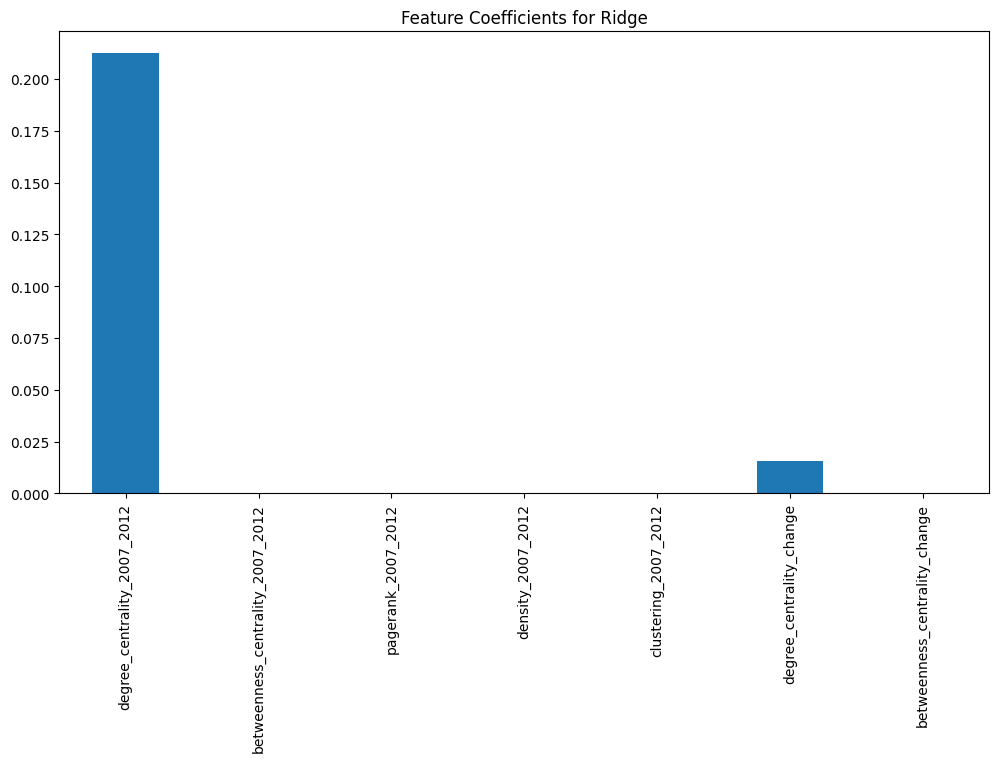

In [66]:
# Feature Importance Visualization (for models that support it)
plt.figure(figsize=(12, 6))
if hasattr(best_model, 'feature_importances_'):
    sns.barplot(x=features, y=best_model.feature_importances_)
    plt.xticks(rotation=90)
    plt.title(f'Feature Importance for {best_model_name}')
    plt.show()
elif isinstance(best_model, Ridge):  # Ridge uses coefficients instead
    coef_importance = pd.Series(best_model.coef_, index=features)
    coef_importance.plot(kind='bar', figsize=(12, 6))
    plt.title(f'Feature Coefficients for {best_model_name}')
    plt.xticks(rotation=90)
    plt.show()


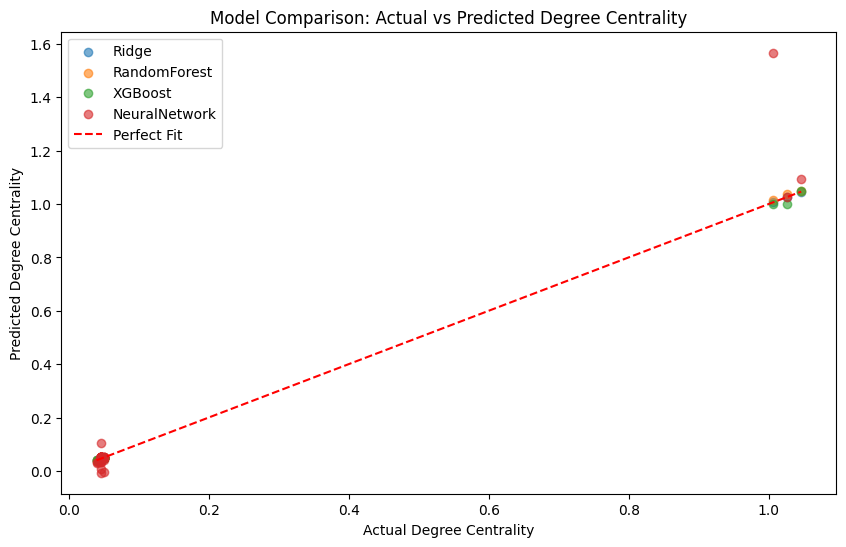

In [67]:
plt.figure(figsize=(10, 6))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plt.scatter(y_test, y_pred, label=name, alpha=0.6)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', label='Perfect Fit')
plt.xlabel('Actual Degree Centrality')
plt.ylabel('Predicted Degree Centrality')
plt.title('Model Comparison: Actual vs Predicted Degree Centrality')
plt.legend()
plt.show()


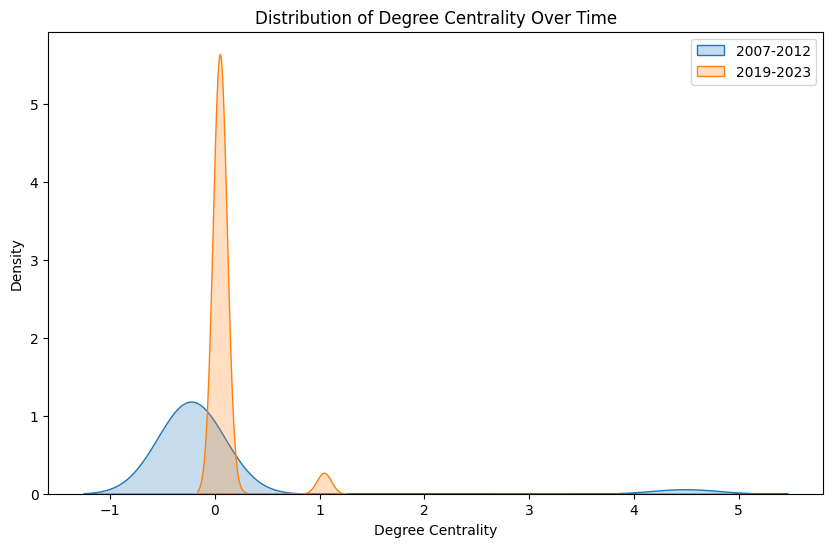

In [68]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_comparison['degree_centrality_2007_2012'], label='2007-2012', fill=True)
sns.kdeplot(df_comparison['degree_centrality_2019_2023'], label='2019-2023', fill=True)
plt.xlabel('Degree Centrality')
plt.ylabel('Density')
plt.title('Distribution of Degree Centrality Over Time')
plt.legend()
plt.show()
